# <center> SAE Velos de Nantes - Partie R2.08</center>

<center> BASOL Nathan - LEDERREY Lussandre - MACCREZ Allan </center>

A partir de la base de données MySQL sur les vélos de Nantes, nous allons valoriser des données en produisant différents indicateurs graphiques. Chaque indicateur répondera à une question precise.



> Importation des packages et modules nécessaires

In [2]:
# importation des packages
import numpy as np
import pandas as pd

# importation des modules
import matplotlib.pyplot as plt
import scipy.stats as sps
import mysql.connector

# warning
import warnings
warnings.filterwarnings('ignore')

> Connexion à la base de données et affichage des tables

In [3]:
# connexion à la base de données
cnx = mysql.connector.connect(user='root', password='basolympe2004', host='127.0.0.1', database='bd_velos_nantes', charset='utf8')

# création du curseur
mycursor = cnx.cursor() 

# affichage des tables
mycursor.execute("SHOW TABLES")

# récupérer toutes les lignes du résultat de la requête
myresult = mycursor.fetchall() 

# afficher les tables
for x in myresult: 
    print(x)  

('comptage',)
('compteur',)
('dateinfo',)
('quartier',)


> Question 1 : Les pistes cyclable de nantes ont elles eu une augmentation d'utilisation sur la période 2020 - 2022 ?

In [4]:
# requête 1 : nombre de passages de vélos par année (sur toute la ville)
requete1 = """
SELECT YEAR(laDate) AS annee, SUM(h00+h01+h02+h03+h04+h05+h06+h07+h08+h09+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23) AS nbVelo
FROM DateInfo, Comptage
WHERE laDate = dateComptage
AND laDate BETWEEN '2020-01-01' AND '2022-12-31'
GROUP BY annee;
"""

# Exécuter la requête
df1 = pd.read_sql(requete1, cnx)

# Afficher le résultat
df1.head()

,annee,nbVelo
0,2020,9250011.0
1,2021,11592739.0
2,2022,13069986.0


> Affichage du résultat de la question 1

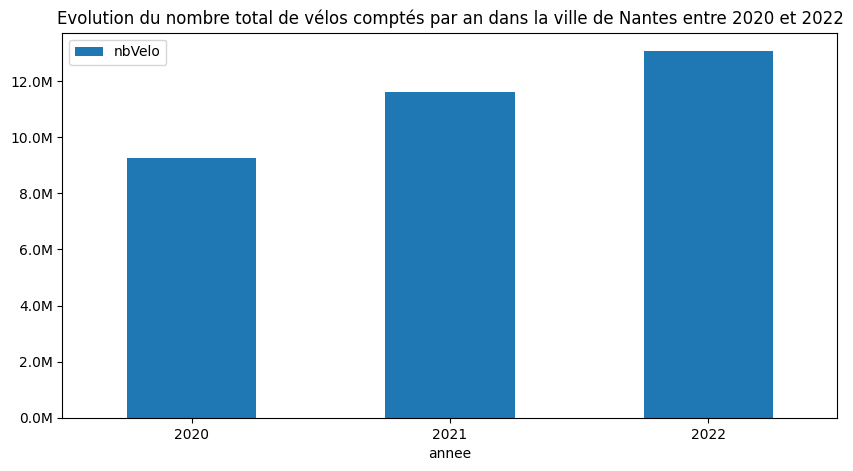

In [5]:
# Convertir les valeurs en millions
df1['nbVelo'] = df1['nbVelo'] / 1000000

# Créer le diagramme en barres
ax = df1.plot.bar(x='annee', y='nbVelo', rot=0, title="Evolution du nombre total de vélos comptés par an dans la ville de Nantes entre 2020 et 2022", figsize=(10, 5))

# Changer l'échelle de l'axe y en millions
ax.set_yticklabels(['{:.1f}M'.format(x) for x in ax.get_yticks()])

# Afficher le diagramme
plt.show()

> Réponse à la question 1


<span style="color:yellow;">Il y a eu une évolution croissante de l'utilisation des pistes cyclables de la ville de Nantes entre 2020 et 2022. On compte environ 2 millions de passages en plus par années. Cette augmentation est certainement liée à la crise sanitaire et aux confinements qui ont eu lieux en 2020. Forcément, l'utilisation des vélos a augmenté les années suivantes.</span>

> Question 2 : Quels sont les quartiers dans lesquels il y a eu le plus de présence d'anomalies fortes ?

In [6]:
# requête 2 : nombre présence anomalie forte par quartiers
requete2 = """
SELECT nomQuartier, COUNT(presenceAnomalie) as nbPresencesAnomalies
FROM Comptage, Compteur, Quartier
WHERE Comptage.leCompteur = Compteur.idCompteur
AND Compteur.leQuartier = Quartier.idQuartier
AND UPPER(presenceAnomalie) = 'FORTE'
GROUP BY nomQuartier
ORDER BY nbPresencesAnomalies DESC;
"""

# Exécuter la requête
df2 = pd.read_sql(requete2, cnx)

# Afficher le résultat
print("Nombre de présences d'anomalies fortes par quartiers :")
print(df2)


Nombre de présences d'anomalies fortes par quartiers :
                 nomQuartier  nbPresencesAnomalies
0  Malakoff - Saint-Donatien                   794
1               Centre Ville                   496
2        Dervalli�res - Zola                   117
3              Ile de Nantes                   103
4              Pont Rousseau                    74
5                      Ragon                    46
6  Hauts Pav�s - Saint F�lix                    42
7                Nantes Nord                    24
8                 Nantes Sud                    16


> Affichage du résultat de la question 2

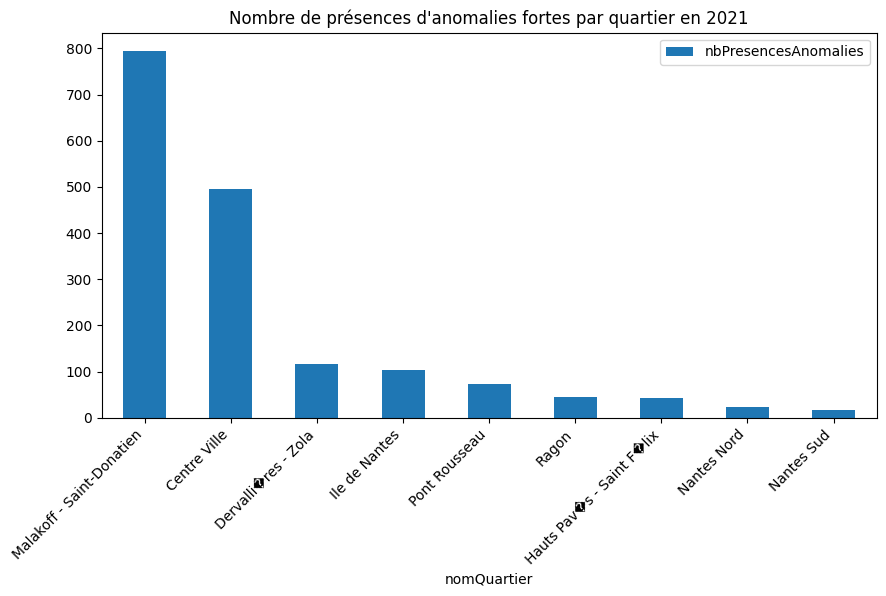

In [7]:
# diagramme en barres
df2.plot.bar(x='nomQuartier', y='nbPresencesAnomalies', rot=0, title="Nombre de présences d'anomalies fortes par quartier en 2021", figsize=(10,5))

# Récupérer l'objet Axes
ax = plt.gca()

# Pivoter les textes sur l'axe des abscisses à 45 degrés
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Afficher le graphique
plt.show()

> Réponse à la question 2


<span style="color:yellow;">On peut voir que les quartiers où il y a eu le plus d'anomalies fortes sont les quartiers de malakoff et du centre ville. On pourrait donc se dire que ces quartiers là possèdent des compteurs déféctueux. Cependant, il faut prendre en compte le fait que tout les quartiers de Nantes ne sont pas autant fréquentés que les autres. Il faudrait donc faire une analyse plus poussé en se demandant si certains quartiers semblent avoir des compteurs défectueux par rapport à la moyenne globale.</span>

> Question 3 : Est ce que certains quartiers ont des compteurs qui sembles déféctueux par rapport à la moyenne ?

In [8]:
# requête 3a  : nombre moyen d'anomalies fortes pour les quartiers
requete3a = """
SELECT(SELECT COUNT(presenceAnomalie) AS nbAnomaliesFortes
       FROM Comptage
       WHERE presenceAnomalie = 'FORTE') /
      (SELECT COUNT(idCompteur) AS nbCompteurs
       FROM Compteur) AS nbAnomaliesFortesMoyenne;
"""

# Exécuter la requête
df3a = pd.read_sql(requete3a, cnx)

# Afficher le résultat
print("Nombre moyen d'anomalies fortes pour les quartiers : ")
df3a.head()

Nombre moyen d'anomalies fortes pour les quartiers : 


,nbAnomaliesFortesMoyenne
0,29.5172


In [9]:
# requête 3b : Pour chaque quartier qui a un nombre d'anomalie forte supérieur à la moyenne,afficher le nombre d'anomalies fortes, le nombre de compteurs et le nombre d'anomalies fortes par compteur
requete3b = """
SELECT nomQuartier, COUNT(presenceAnomalie) as nbPresencesAnomalies, COUNT(DISTINCT idCompteur) AS nbCompteurs, COUNT(presenceAnomalie) / COUNT(DISTINCT idCompteur) as nbAnoParCpt
FROM Comptage, Compteur, Quartier
WHERE Comptage.leCompteur = Compteur.idCompteur
AND Compteur.leQuartier = Quartier.idQuartier
AND presenceAnomalie = 'FORTE'
GROUP BY nomQuartier
HAVING COUNT(presenceAnomalie) / COUNT(DISTINCT idCompteur) > (SELECT(SELECT COUNT(presenceAnomalie) AS nbAnomaliesFortes
                                                               FROM Comptage
                                                               WHERE presenceAnomalie = 'FORTE') /
                                                               (SELECT COUNT(idCompteur) AS nbCompteurs
                                                               FROM Compteur) AS nbAnomaliesFortesMoyenneParQuartier);
"""

# Exécuter la requête
df3b = pd.read_sql(requete3b, cnx)

# Afficher le résultat
print("Quartiers ayant un nombre d'anomalies fortes par compteur supérieur à la moyenne :")
df3b.head()

Quartiers ayant un nombre d'anomalies fortes par compteur supérieur à la moyenne :


,nomQuartier,nbPresencesAnomalies,nbCompteurs,nbAnoParCpt
0,Dervalli�res - Zola,117,1,117.0000
1,Malakoff - Saint-Donatien,794,7,113.4286
2,Pont Rousseau,74,2,37.0000


In [10]:
# requête 3c : Pour chaque quartier, afficher le nombre d'anomalies fortes, le nombre de compteurs et le nombre d'anomalies fortes par compteur
requete3c = """
SELECT nomQuartier, COUNT(presenceAnomalie) as nbPresencesAnomalies, COUNT(DISTINCT idCompteur) AS nbCompteurs, COUNT(presenceAnomalie) / COUNT(DISTINCT idCompteur) as nbAnoParCpt
FROM Comptage, Compteur, Quartier
WHERE Comptage.leCompteur = Compteur.idCompteur
AND Compteur.leQuartier = Quartier.idQuartier
AND presenceAnomalie = 'FORTE'
GROUP BY nomQuartier
ORDER BY nbAnoParCpt DESC;
"""

# Exécuter la requête
df3c = pd.read_sql(requete3c, cnx)

# Afficher le résultat
print("Pour chaque quartier, nombre d'anomalies fortes, nombre de compteurs et nombre d'anomalies fortes par compteur :")
print(df3c)

Pour chaque quartier, nombre d'anomalies fortes, nombre de compteurs et nombre d'anomalies fortes par compteur :
                 nomQuartier  nbPresencesAnomalies  nbCompteurs  nbAnoParCpt
0        Dervalli�res - Zola                   117            1     117.0000
1  Malakoff - Saint-Donatien                   794            7     113.4286
2              Pont Rousseau                    74            2      37.0000
3               Centre Ville                   496           18      27.5556
4                Nantes Nord                    24            1      24.0000
5                      Ragon                    46            2      23.0000
6              Ile de Nantes                   103            6      17.1667
7  Hauts Pav�s - Saint F�lix                    42            4      10.5000
8                 Nantes Sud                    16            2       8.0000


> Affichage du résultat de la question 3

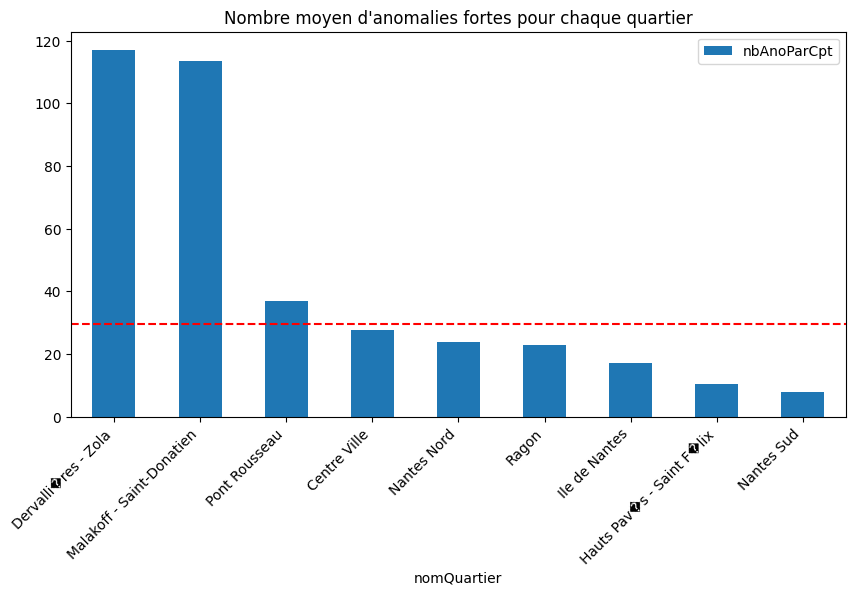

In [11]:
# Créer le diagramme en barres
ax = df3c.plot.bar(x='nomQuartier', y='nbAnoParCpt', rot=0, title="Nombre moyen d'anomalies fortes pour chaque quartier", figsize=(10, 5))

# Requête 3d : nombre moyen d'anomalies fortes par compteur
requete3d = """
SELECT (SELECT COUNT(presenceAnomalie) AS nbAnomaliesFortes
        FROM Comptage
        WHERE presenceAnomalie = 'FORTE') /
       (SELECT COUNT(idCompteur) AS nbCompteurs
        FROM Compteur) AS nbAnomaliesFortesMoyenneParQuartier;
"""

# Exécuter la requête
df3d = pd.read_sql(requete3d, cnx)

# Récupérer la valeur cible
valeur_cible = df3d['nbAnomaliesFortesMoyenneParQuartier'][0]

# Ajouter la ligne horizontale pour la valeur cible
ax.axhline(y=valeur_cible, color='red', linestyle='--', label='Valeur cible')

# Pivoter les textes sur l'axe des abscisses à 45 degrés
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Afficher le diagramme
plt.show()

> Réponse question 3



<span style="color:yellow;">On voit donc sur ce diagramme que la moyenne d'anomalie forte est d'environ 30 par quartiers. 3 quartiers dépassent cette limite. Il serait donc utile d'aller vérifier et réparer les compteurs dans les quartiers de Zola, Malakoff-Saint-Donatien et Pont Rousseau. On remarque que le nombre moyen d'anomalies fortes sur les compteurs du centre ville n'est pas au dessus de la moyenne alors que le centre ville possède énormément d'anomalies fortes. Cela vient du fait que ce quartier possède beaucoup de compteurs. On pourrait donc maintenant se pencher sur les compteurs.</span>

> Question 4 : Est ce que tout les quartiers possèdent des compteurs ?

In [12]:
# requête 4 : nombre de compteurs par quartier
requete4 = """
SELECT nomQuartier, COUNT(idCompteur) AS nbCompteurs
FROM Quartier 
    LEFT JOIN Compteur ON Quartier.idQuartier = Compteur.leQuartier
GROUP BY nomQuartier
ORDER BY nbCompteurs DESC;
"""

# Exécuter la requête
df4 = pd.read_sql(requete4, cnx)

# Afficher le résultat
print(df4)

                           nomQuartier  nbCompteurs
0                         Centre Ville           22
1            Malakoff - Saint-Donatien            9
2                        Ile de Nantes            6
3            Hauts Pav�s - Saint F�lix            4
4                          Nantes Nord            2
5                    Doulon - Botti�re            2
6                           Nantes Sud            2
7                        Pont Rousseau            2
8                                Ragon            2
9                  Dervalli�res - Zola            1
10  Bellevue - Chantenay - Sainte Anne            0
11                    Breil - Barberie            0
12                        Nantes Erdre            0
13                         Trentemoult            0
14                      H�tel de Ville            0
15                     Ch�teau de Rez�            0
16                         La Houssais            0
17                           Blordi�re            0


> Affichage du résultat de la question 4

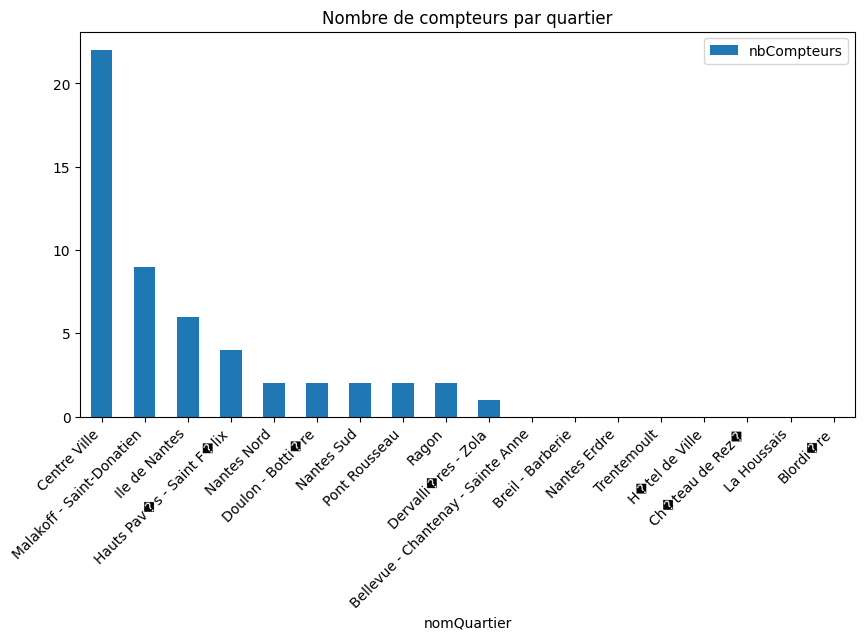

In [13]:
# diagramme en barres
ax = df4.plot.bar(x='nomQuartier', y='nbCompteurs', rot=0, title="Nombre de compteurs par quartier", figsize=(10,5))

# Pivoter les textes sur l'axe des abscisses à 45 degrés
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Afficher le graphique
plt.show()

> Réponse à la question 4


<span style="color:yellow;">Non, beaucoup de quartier n'ont aucun compteur. Seulement 10 quartiers en possèdent. Le centre ville possède beaucoup de compteurs par rapport aux autres quartiers. Il serait donc intéressant de se demander si il faut rajouter des compteurs dans les quartiers qui n'en possèdent pas.</span>

> Question 5 : Faut il rajouter des compteurs dans les quartiers qui n'en possèdent pas ?

In [14]:
# requête 5a : longueur totale des pistes cyclables pour tous les quartiers
requete5a = """
SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
FROM Quartier;
"""

# Exécuter la requête
df5a = pd.read_sql(requete5a, cnx)

# Afficher le résultat
print("Longueur totale des pistes cyclables pour tous les quartiers : ")
df5a.head()


Longueur totale des pistes cyclables pour tous les quartiers : 


,longueurTotalPisteVelo
0,329131.197754


In [15]:
# requête 5b : longueur totale des pistes cyclables pour les quartiers sans compteur
requete5b = """
SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
FROM Quartier 
    LEFT JOIN Compteur ON Quartier.idQuartier = Compteur.leQuartier
WHERE idCompteur IS NULL;
"""

# Exécuter la requête
df5b = pd.read_sql(requete5b, cnx)

# Afficher le résultat
print()
print("Longueur totale des pistes cyclables pour les quartiers sans compteur : ")
df5b.head()


Longueur totale des pistes cyclables pour les quartiers sans compteur : 


,longueurTotalPisteVelo
0,104143.699219


In [16]:
# requête 5c : pourcentage de piste cyclable qui n'est pas couverte par un compteur
requete5c = """
SELECT (SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
        FROM Quartier
        LEFT JOIN Compteur ON Quartier.idQuartier = Compteur.leQuartier
        WHERE idCompteur IS NULL) /
       (SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
        FROM Quartier) *100 AS ratio;
"""

# requête 5d : pourcentage de piste cyclable qui est couverte par un compteur
requete5d = """
SELECT ((SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
        FROM Quartier) - 
         (SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
        FROM Quartier 
            LEFT JOIN Compteur ON Quartier.idQuartier = Compteur.leQuartier
        WHERE idCompteur IS NULL)) /
         (SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
        FROM Quartier) *100 AS ratio;
"""

# Exécuter les requête
df5c = pd.read_sql(requete5c, cnx)
df5d = pd.read_sql(requete5d, cnx)

# concatener le resultat dans un seul dataframe
df5e = pd.concat([df5c, df5d], ignore_index=True)

# Afficher le résultat
print()
print("Pourcentage de piste cyclable qui n'est pas couverte par un compteur (0) et qui est couverte par un compteur (1) : ")
df5e.head()


Pourcentage de piste cyclable qui n'est pas couverte par un compteur (0) et qui est couverte par un compteur (1) : 


,ratio
0,31.642002
1,68.357998


> Affichage du résultat de la question 5 (partie 1)

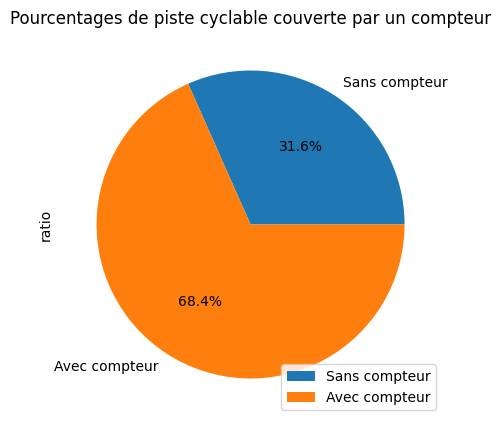

In [17]:
# graphique diagramme circulaire
df5e.plot.pie(y='ratio', labels=['Sans compteur', 'Avec compteur'], autopct='%1.1f%%', title="Pourcentages de piste cyclable couverte par un compteur", figsize=(10,5))

# Afficher le graphique
plt.show()


> Réponse à la question 5


<span style="color:yellow;">Il y a donc environ 31% de piste cyclable qui n'est pas comptabilisé par un capteur. Il serait donc intéressant de rajouter des compteurs dans les quartiers qui n'en possèdent pas. Il faudrait en priporité privilégier les plus longues pistes cyclables. Pour cela, voici une requête qui nous les montres.</span>

In [18]:
# requête 5d : longueur des pistes cyclables pour chaque quartier sans compteur
requete5d = """
SELECT nomQuartier, SUM(longueurPisteVelo) AS longueurTotalPisteVelo
FROM Quartier
    LEFT JOIN Compteur ON Quartier.idQuartier = Compteur.leQuartier
WHERE idCompteur IS NULL
GROUP BY nomQuartier
ORDER BY longueurTotalPisteVelo DESC;
"""

# Exécuter la requête
df5d = pd.read_sql(requete5d, cnx)

# Afficher le résultat
print()
print("Longueur totale des pistes cyclables pour les quartiers sans compteur : ")
print(df5d)


Longueur totale des pistes cyclables pour les quartiers sans compteur : 
                          nomQuartier  longueurTotalPisteVelo
0                        Nantes Erdre            31816.199219
1  Bellevue - Chantenay - Sainte Anne            22597.300781
2                    Breil - Barberie            16718.199219
3                         La Houssais             9288.900391
4                         Trentemoult             7854.500000
5                     Ch�teau de Rez�             6371.500000
6                      H�tel de Ville             4808.799805
7                           Blordi�re             4688.299805


<span style="color:yellow;">Il faut donc rajouter des compteurs en priorité dans les quartiers de Nantes Erdre, Bellevue-Chantenay-Sainte Anne et Breil-Barberie.</span>

> Question 6 : Existe il une corrélation entre la température et le nombre de passages sur les pistes cyclables ?

In [19]:
# requête 6a : Pour chaque mois sur 3 ans, la température moyenne et le nombre total de passagers
requete6a = """
SELECT MONTHNAME(laDate) AS mois, AVG(tempMoy) AS temperatureMoyenne, SUM(h00+h01+h02+h03+h04+h05+h06+h07+h08+h09+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23) AS nbTotalPassagers
FROM DateInfo, Comptage
WHERE laDate BETWEEN '2020-01-01' AND '2022-12-31'
AND laDate = dateComptage
GROUP BY mois
ORDER BY nbTotalPassagers;
"""

# Exécuter la requête
df6a = pd.read_sql(requete6a, cnx)

# Afficher le résultat
print()
print("Pour chaque mois sur 3 ans, la température moyenne et le nombre total de passagers : ")
print(df6a)



Pour chaque mois sur 3 ans, la température moyenne et le nombre total de passagers : 
         mois  temperatureMoyenne  nbTotalPassagers
0    December            6.997936         2114516.0
1       April           12.373933         2160477.0
2    February            8.458564         2260362.0
3     January            6.137490         2344741.0
4       March            9.608484         2622089.0
5      August           21.030383         2638275.0
6    November            9.586242         2853858.0
7         May           15.665188         2867877.0
8        July           20.822078         3034753.0
9        June           18.868374         3469527.0
10    October           14.251162         3496815.0
11  September           18.424315         4049446.0


> Affichage du résultat de la question 6

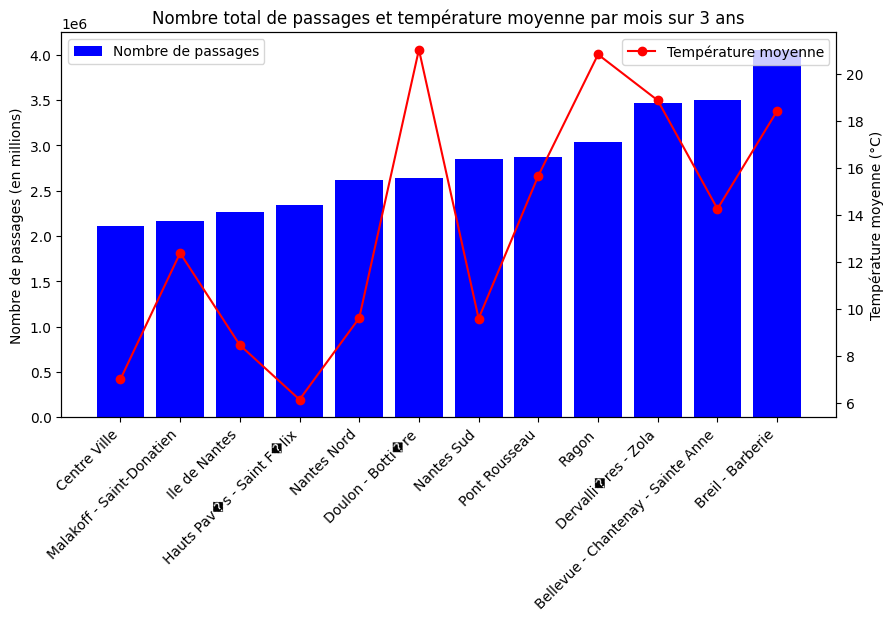

In [20]:
# Créer la figure et les axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Créer le diagramme en barres pour le nombre total de passagers
ax1.bar(df6a['mois'], df6a['nbTotalPassagers'], color='blue')
ax1.set_ylabel("Nombre de passages (en millions)")

# Créer un axe secondaire pour la température moyenne
ax2 = ax1.twinx()
ax2.plot(df6a['mois'], df6a['temperatureMoyenne'], color='red', marker='o')
ax2.set_ylabel("Température moyenne (°C)")

# Ajouter une légende
ax1.legend(["Nombre de passages"], loc='upper left')
ax2.legend(["Température moyenne"], loc='upper right')

# Ajouter un titre
plt.title("Nombre total de passages et température moyenne par mois sur 3 ans")

# Pivoter les textes sur l'axe des abscisses à 45 degrés
ax1.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Afficher le diagramme
plt.show()



> Réponse à la question 6 (partie 1)

<span style="color:yellow;">On remarque que la température n'influe pas forcément sur le nombres de cycliste. Pour les mois d'août, il a fait une température moyenne de 20 degrés mais le nombre de passages n'est pas vraiment élevé par rapport aux autres mois. En revanche, pour les mois d'octobre, il a fait environ 14 degré mais c'est le deuxième mois qui comptabilise le plus de passages. Cependant, on remarque quand même que quand il fait très froid (décembre, janvier, février), il y a une tendance avec peu de passages. De ce fait, on pourrait préciser le graphique en regardant par rapport aux saisons. </span>


In [21]:
# requête 6b : Pour chaque saison sur 3 ans, la température moyenne et le nombre total de passagers
requete6b = """
SELECT CASE
           WHEN MONTH(laDate) BETWEEN 3 AND 5 THEN 'PRINTEMPS'
           WHEN MONTH(laDate) BETWEEN 6 AND 8 THEN 'ETE'
           WHEN MONTH(laDate) BETWEEN 9 AND 11 THEN 'AUTOMNE'
           ELSE 'HIVER'
       END AS saison, AVG(tempMoy) AS temperatureMoyenne, SUM(h00+h01+h02+h03+h04+h05+h06+h07+h08+h09+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23) AS nbTotalPassagers
FROM DateInfo, Comptage
WHERE laDate BETWEEN '2020-01-01' AND '2022-12-31'
AND laDate = dateComptage
GROUP BY saison
ORDER BY nbTotalPassagers;
"""

# Exécuter la requête
df6b = pd.read_sql(requete6b, cnx)

# Afficher le résultat
print()
print("Pour chaque saison sur 3 ans, la température moyenne et le nombre total de passagers : ")
df6b.head()


Pour chaque saison sur 3 ans, la température moyenne et le nombre total de passagers : 


,saison,temperatureMoyenne,nbTotalPassagers
0,HIVER,7.160796,6719619.0
1,PRINTEMPS,12.551742,7650443.0
2,ETE,20.249747,9142555.0
3,AUTOMNE,14.089041,10400119.0


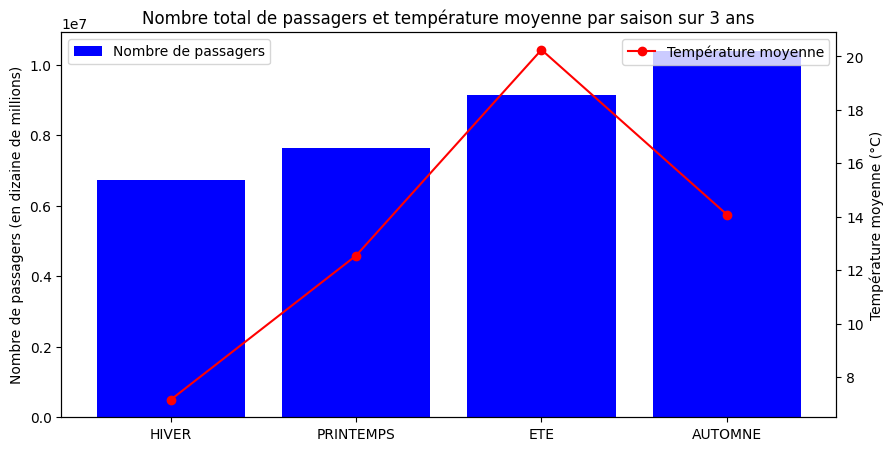

In [22]:
# Création de la figure et des axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Création diagramme en barres pour le nombre total de passagers
passagers_bar = ax1.bar(df6b['saison'], df6b['nbTotalPassagers'], color='blue')
ax1.set_ylabel("Nombre de passagers (en dizaine de millions)")

# Création axe secondaire pour la température moyenne
ax2 = ax1.twinx()
temperature_line = ax2.plot(df6b['saison'], df6b['temperatureMoyenne'], color='red', marker='o')
ax2.set_ylabel("Température moyenne (°C)")

# légende
ax1.legend(passagers_bar, ["Nombre de passagers"], loc='upper left')
ax2.legend(temperature_line, ["Température moyenne"], loc='upper right')

# titre
plt.title("Nombre total de passagers et température moyenne par saison sur 3 ans")

# Ajuster des positions des barres sur l'axe des abscisses
ax1.set_xticks(np.arange(len(df6b['saison'])))
ax1.set_xticklabels(df6b['saison'])

# Afficher le diagramme
plt.show()



> Réponse à la question 6 (partie 2)

<span style="color:yellow;"> Ce diagramme nous montre bien que plus la température augmente au fil des saisons, plus le nombre de passages est élevé. Or, on remarque que c'est en automne qu'il y a le plus de passages alors que la température moyenne est de 14 degrés contre 20 degrés en été. De ce fait, il n'y a pas forcémment de corrélation entre la température et le nombre de passages, en particulier pour l'automne  </span>

> Question 7 :  Dans le quartier Ile de Nantes, pendant quelles vacances de 2021 y a-t-il le plus de passages moyens par jours ?

In [23]:
# requête 7 : Pour chaque vacances de 2021, nombre de passages moyen par jour pour le quartier Ile de Nantes
requete7 = """
SELECT vacances, CASE WHEN vacances = "Ascension" THEN (SUM(h00 + h01 + h02 + h03 + h04 + h05 + h06 + h07 + h08 + h09 + h10 + h11 + h12 + h13 + h14 + h15 + h16 + h17 + h18 + h19 + h20 + h21 + h22 + h23) / 5)
            WHEN vacances = "Eté" THEN (SUM(h00 + h01 + h02 + h03 + h04 + h05 + h06 + h07 + h08 + h09 + h10 + h11 + h12 + h13 + h14 + h15 + h16 + h17 + h18 + h19 + h20 + h21 + h22 + h23) / 56)
            WHEN vacances = "Toussaint" THEN (SUM(h00 + h01 + h02 + h03 + h04 + h05 + h06 + h07 + h08 + h09 + h10 + h11 + h12 + h13 + h14 + h15 + h16 + h17 + h18 + h19 + h20 + h21 + h22 + h23) / 16)
            WHEN vacances = "Hiver" THEN (SUM(h00 + h01 + h02 + h03 + h04 + h05 + h06 + h07 + h08 + h09 + h10 + h11 + h12 + h13 + h14 + h15 + h16 + h17 + h18 + h19 + h20 + h21 + h22 + h23) / 16)
            WHEN vacances = "Noël" THEN (SUM(h00 + h01 + h02 + h03 + h04 + h05 + h06 + h07 + h08 + h09 + h10 + h11 + h12 + h13 + h14 + h15 + h16 + h17 + h18 + h19 + h20 + h21 + h22 + h23) / 16)
            WHEN vacances = "Printemps" THEN (SUM(h00 + h01 + h02 + h03 + h04 + h05 + h06 + h07 + h08 + h09 + h10 + h11 + h12 + h13 + h14 + h15 + h16 + h17 + h18 + h19 + h20 + h21 + h22 + h23) / 16)
            END AS veloParJour            
FROM DateInfo 
    LEFT JOIN Comptage ON laDate = dateComptage
    LEFT JOIN Compteur ON leCompteur = idCompteur
    LEFT JOIN Quartier ON leQuartier = idQuartier
WHERE nomQuartier = 'Ile de Nantes'
AND sens = 'Nord'
AND vacances IS NOT null
AND YEAR(laDate) = 2021
GROUP BY vacances
ORDER BY veloParJour;
"""

# Exécuter la requête
df7 = pd.read_sql(requete7, cnx)

# Afficher le résultat
print()
print("Pour chaque vacances de 2021, nombre de passages moyen par jour pour le quartier Ile de Nantes : ")
print(df7)


Pour chaque vacances de 2021, nombre de passages moyen par jour pour le quartier Ile de Nantes : 
    vacances  veloParJour
0  Ascension    1580.0000
1       Noel    1583.8750
2      Hiver    2512.5625
3  Printemps    3074.0000
4  Toussaint    3156.3750
5        Ete    3231.1607


> Affichage du résultat de la question 7

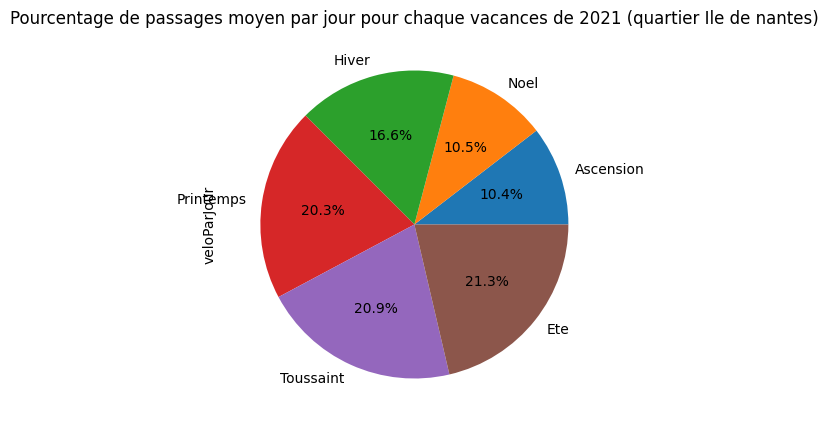

In [24]:
# diagramme circulaire
df7.plot.pie(y='veloParJour', labels=df7['vacances'], figsize=(5, 5), autopct='%1.1f%%', legend=False, title="Pourcentage de passages moyen par jour pour chaque vacances de 2021 (quartier Ile de nantes)")

# Afficher le diagramme
plt.show()

> Réponse à la question 7

<span style="color:yellow;"> D'après ce diagramme circulaire, on voit qu'il y a eu a peu près le même nombres de passages moyen par jour pour les vacances d'été, de Toussaint et de Printemps. Ce sont donc les 3 vacances ou il y a eu le plus de passsage moyen par jours en 2021 dans le quartier Ile de Nantes. Les résultats semblent logique notamment pour la Toussaint car on sait maintenant qu'il y a beaucoup de passages de cyclistes à Nantes en automne. </span>